# Unbalanced classes - tentativo di ribilanciamento
In questo notebook è riportata un tentativo di ribilanciamento delle classi del dataset, in quanto la classe 4 risulta essere molto meno rappresentata rispetto alle altre.

Prima viene incrementata la classe minoritaria con image augmentation geometriche e di brightness applicate alla sola immagine con il maggior numero di pixel appartenenti alla classe 4 (questo per evitare l'eccessivo incremento delle classi maggioritarie). Successivamente vengono ricercate le immagini avanti una delle altre classi predominanti (90%) e vengono eliminate per fare un downsample delle classi maggioritarie.

Questo tentativo ha portato ad un leggero ribilanciamento ma non completo. Inoltre, ha causato un abbassamento delle performance di qualsiasi modello gli sia stato applicato, probabilmente perchè il downsample delle classi maggioritarie ha portato a troppa perdita di informazione. Per questo motivo è stato abbandonato, continuando a lavorare con lo sbilanciamento delle classi presente.

**Connect Colab to Google Drive**

In [ ]:
from google.colab import drive
drive.mount("/gdrive")

%cd /gdrive/My Drive/U-net

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/U-net


**Import Libraries**

In [ ]:

import os
from datetime import datetime

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
seed = 42

**Load the Data**

In [ ]:
data = np.load("mars_for_students_processed.npz")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
from matplotlib.colors import ListedColormap

# un colore per classe
class_colors = {
    0: "black",     # Background
    1: "brown",     # Soil
    2: "gray",      # Bedrock
    3: "yellow",    # Sand
    4: "darkgreen"  # Big Rock
}

cmap = ListedColormap([class_colors[key] for key in sorted(class_colors.keys())])

In [ ]:
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)


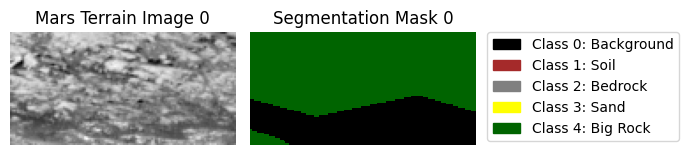

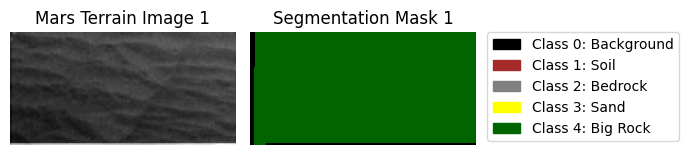

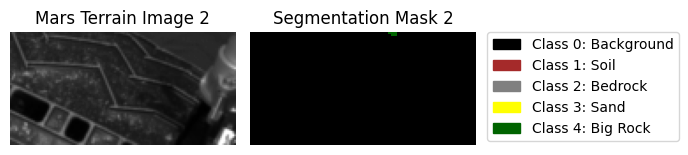

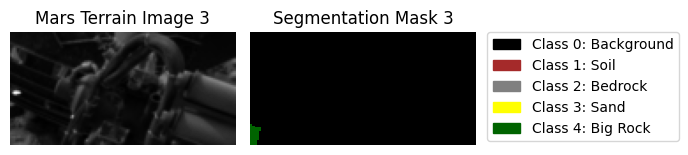

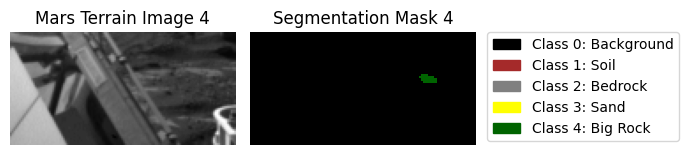

In [ ]:
# preparo la legenda
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=class_colors[i], label=f"Class {i}: {label}")
                  for i, label in enumerate(["Background", "Soil", "Bedrock", "Sand", "Big Rock"])]

def display_images_with_masks(X_train, y_train, start, end):
    for i in range(start, end):
        image = X_train[i]
        mask = y_train[i]

        # Plot immagine e maschera
        plt.figure(figsize=(7, 5))

        # Immagine
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Mars Terrain Image {i}")
        plt.axis("off")

        # Maschera
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap=cmap, interpolation="none")
        plt.title(f"Segmentation Mask {i}")
        plt.axis("off")

        # legenda
        plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()

display_images_with_masks(X_train, y_train, start=0, end=5)

In [ ]:
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)


## Distribuzione delle classi

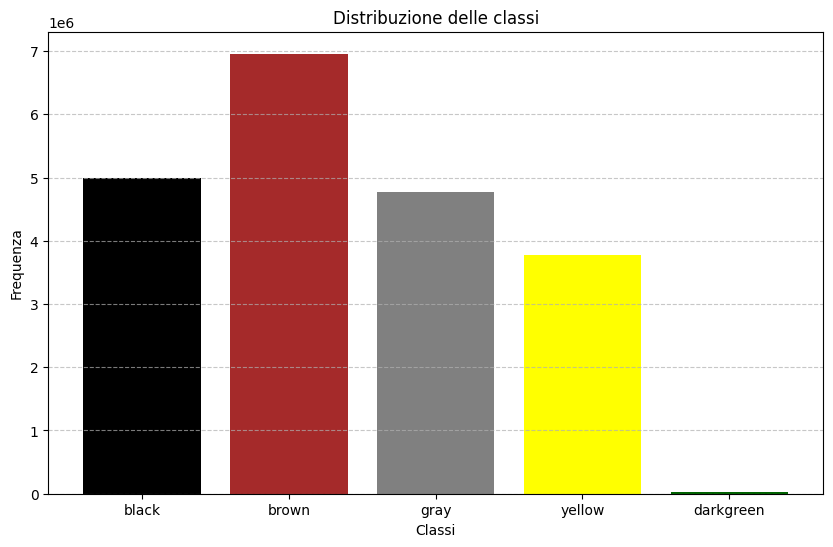

In [ ]:
# Istogramma delle classi
class_counts = np.zeros(len(class_colors), dtype=int)
for mask in y_train:
    for cls in range(len(class_colors)):
        class_counts[cls] += np.sum(mask == cls)

# Plot dell'istogramma
plt.figure(figsize=(10, 6))
plt.bar(class_colors.values(), class_counts, color=[class_colors[k] for k in class_colors])
plt.title("Distribuzione delle classi")
plt.xlabel("Classi")
plt.ylabel("Frequenza")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Osservazione:** in questo istogramma è evidente lo sbilanciamento della classe 4 (darkgreen) rispetto alle altre. Quindi splitto in due i dati: da un lato le sole immagini e relative maschere che presentino la classe 4, dall'altro il resto.

In [ ]:
# Trova gli indici delle maschere che contengono la classe 4
class_4_mask = np.any(y_train == 4, axis=(1, 2))

# Separa il dataset in due gruppi
X_train_class_4 = X_train[class_4_mask]
y_train_class_4 = y_train[class_4_mask]

X_train_other_classes = X_train[~class_4_mask]
y_train_other_classes = y_train[~class_4_mask]

In [ ]:
print(f"X_train_class_4 shape: {X_train_class_4.shape}")
print(f"y_train_class_4 shape: {y_train_class_4.shape}")
print(f"X_train_other_classes shape: {X_train_other_classes.shape}")
print(f"y_train_other_classes shape: {y_train_other_classes.shape}")

X_train_class_4 shape: (63, 64, 128)
y_train_class_4 shape: (63, 64, 128)
X_train_other_classes shape: (2442, 64, 128)
y_train_other_classes shape: (2442, 64, 128)


In [ ]:
# estraggo immagini con almeno 30% classe 4
def find_image_with_at_least_30_percent_class_4(images, masks):

    X_img = []
    y_mask = []

    for i, mask in enumerate(masks):
        unique, counts = np.unique(mask, return_counts=True)
        total_pixels = mask.size
        class_4_pixels = counts[unique == 4]

        # Verifica se almeno il 90% dei pixel è della classe 4
        if class_4_pixels > 0 and (class_4_pixels / total_pixels) >= 0.3:
            X_img.append(images[i])
            y_mask.append(mask)
    return np.array(X_img), np.array(y_mask)

# Usa la funzione con i tuoi dati
X_img_4_03, y_mask_4_03 = find_image_with_at_least_30_percent_class_4(X_train_class_4, y_train_class_4)

if X_img_4_03 is not None:
    print("Trovata immagine con almeno il 30% di classe 4")
    print("Immagine shape:", X_img_4_03.shape)
    print("Maschera shape:", y_mask_4_03.shape)
else:
    print("Nessuna immagine trovata con almeno il 30% di classe 4")

Trovata immagine con almeno il 30% di classe 4
Immagine shape: (1, 64, 128)
Maschera shape: (1, 64, 128)


In [ ]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Training X shape: {X_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


## Image augmentation
Incremento la classe 4 incrementando il numero di immagini e maschere applicando all'immagine trovata le augmentations.

Flipped Image Shape: (1, 64, 128)
Flipped Mask Shape: (1, 64, 128)


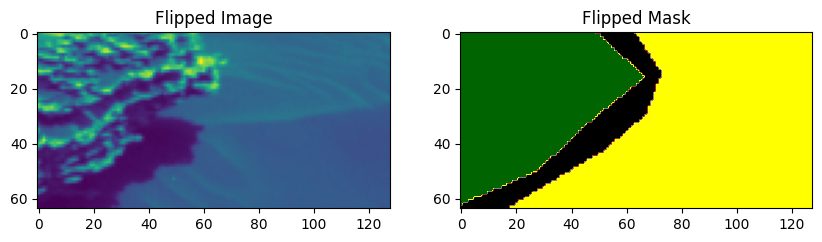

In [ ]:
# Flip up down

X_class_4_tensor = tf.convert_to_tensor(X_img_4_03, dtype=tf.float64)
y_class_4_tensor = tf.convert_to_tensor(y_mask_4_03, dtype=tf.float64)

flipped_image = tf.image.flip_up_down(X_class_4_tensor)
flipped_mask = tf.image.flip_up_down(y_class_4_tensor)

print("Flipped Image Shape:", flipped_image.shape)
print("Flipped Mask Shape:", flipped_mask.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(flipped_image[0])
plt.title("Flipped Image")
plt.subplot(1, 2, 2)
plt.imshow(flipped_mask[0], cmap=cmap)
plt.title("Flipped Mask")
plt.show()

In [ ]:
# Flip left right

flipped_image_lr = tf.image.flip_left_right(X_class_4_tensor)
flipped_mask_lr = tf.image.flip_left_right(y_class_4_tensor)

X_aug_4 = np.append(X_class_4_tensor, flipped_image_lr, axis=0)
y_aug_4 = np.append(y_class_4_tensor, flipped_mask_lr, axis=0)

print(X_aug_4.shape)
print(y_aug_4.shape)

(2, 64, 128)
(2, 64, 128)


In [ ]:
# Rotation di 180

rotated_image_180 = tf.image.rot90(X_class_4_tensor, k=2)
rotated_mask_180 = tf.image.rot90(y_class_4_tensor, k=2)

X_aug_4 = np.append(X_aug_4, rotated_image_180, axis=0)
y_aug_4 = np.append(y_aug_4, rotated_mask_180, axis=0)

print(X_aug_4.shape)
print(y_aug_4.shape)

(3, 64, 128)
(3, 64, 128)


In [ ]:
X_aug_4 = X_aug_4[np.newaxis, ...]
y_aug_4 = y_aug_4[np.newaxis, ...]

print(f"Training X shape: {X_aug_4.shape}")
print(f"Test X shape: {y_aug_4.shape}")

Training X shape: (1, 3, 64, 128)
Test X shape: (1, 3, 64, 128)


In [ ]:
# Brightness

# Creazione di un dataset temporaneo
dataset = tf.data.Dataset.from_tensor_slices((X_aug_4, y_aug_4))

# Definizione dei fattori di luminosità
brightness_factors = np.arange(0.02, 0.42, 0.02)  # Genera fattori diversi

# Applicazione della variazione di luminosità per ogni fattore
variations = []

for factor in brightness_factors:
    def apply_brightness(image, mask):
        bright_image = tf.image.random_brightness(image, factor)
        return bright_image, mask  # La maschera rimane invariata

    dataset_variation = dataset.map(apply_brightness, num_parallel_calls=tf.data.AUTOTUNE)
    variations.append(dataset_variation)

# Inizializza un array vuoto per accumulare tutte le immagini e maschere modificate
X_aug_4_list = []
y_aug_4_list = []

# Aggiungi tutte le variazioni
for variation in variations:
    for img, mask in variation:
        X_aug_4_list.append(img.numpy())  # Converti tensor a numpy array
        y_aug_4_list.append(mask.numpy())  # Converti tensor a numpy array

# Concatena le immagini e le maschere in un singolo array
X_aug_4 = np.concatenate(X_aug_4_list, axis=0)
y_aug_4 = np.concatenate(y_aug_4_list, axis=0)

print(X_aug_4.shape)
print(y_aug_4.shape)

(60, 64, 128)
(60, 64, 128)


In [ ]:
X_aug_4 = X_aug_4[... , np.newaxis]
X_train_check = np.append(X_train, X_aug_4, axis=0)
y_train_check = np.append(y_train, y_aug_4, axis=0)
print(f"Training X shape: {X_train_check.shape}")
print(f"Training y shape: {y_train_check.shape}")

Training X shape: (2565, 64, 128, 1)
Training y shape: (2565, 64, 128)


## Nuova distribuzione delle classi

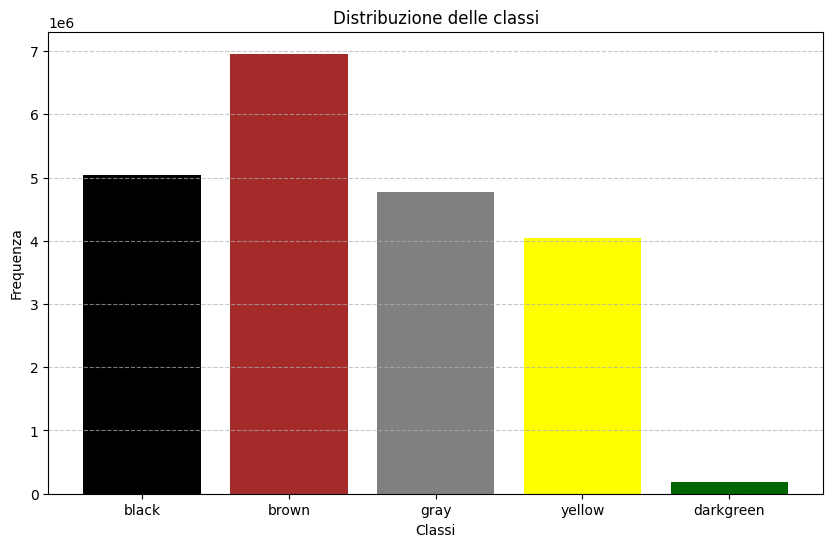

In [ ]:
# Distribuzione delle classi

# Istogramma delle classi
class_counts = np.zeros(len(class_colors), dtype=int)
for mask in y_train_check:
    for cls in range(len(class_colors)):
        class_counts[cls] += np.sum(mask == cls)

# Plot dell'istogramma
plt.figure(figsize=(10, 6))
plt.bar(class_colors.values(), class_counts, color=[class_colors[k] for k in class_colors])
plt.title("Distribuzione delle classi")
plt.xlabel("Classi")
plt.ylabel("Frequenza")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Osservazione:** la classe darkgreen è incrementata mantenendo pressochè simili le classi maggioritarie.

## Downsampling classi maggioritarie

**CLASSE 1**

In [ ]:
# Estraggo solo le immagini che hanno % alta di classe 1
def find_image_with_at_least_90_percent_class_1(images, masks):

    X_img = []
    y_mask = []
    index = []

    for i, mask in enumerate(masks):
        unique, counts = np.unique(mask, return_counts=True)
        total_pixels = mask.size
        class_1_pixels = counts[unique == 1]

        # Verifica se almeno il 90% dei pixel è della classe 1
        if class_1_pixels > 0 and (class_1_pixels / total_pixels) >= 0.9:
            X_img.append(images[i])
            y_mask.append(mask)
            index.append(i)
    return np.array(X_img), np.array(y_mask), index

# Usa la funzione con i tuoi dati
X_img_1_09, y_mask_1_09, index_1_09 = find_image_with_at_least_90_percent_class_1(X_train_other_classes, y_train_other_classes)

if X_img_1_09 is not None:
    print("Trovata immagine con almeno il 90% di classe 1")
    print("Immagine shape:", X_img_1_09.shape)
    print("Maschera shape:", y_mask_1_09.shape)
else:
    print("Nessuna immagine trovata con almeno il 90% di classe 1")

<ipython-input-23-abb95fe60c0a>:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if class_1_pixels > 0 and (class_1_pixels / total_pixels) >= 0.9:


Trovata immagine con almeno il 30% di classe 1
Immagine shape: (640, 64, 128)
Maschera shape: (640, 64, 128)


In [ ]:
# Cancello le immagini con gli indici di index_1_09 dal dataset X_train_other_classes

X_train_other_classes = np.delete(X_train_other_classes, index_1_09, axis=0)
X_train_other_classes = X_train_other_classes[..., np.newaxis]
print(X_train_other_classes.shape)

(1802, 64, 128, 1)


In [ ]:
# Cancello le maschere

y_train_other_classes = np.delete(y_train_other_classes, index_1_09, axis=0)
print(y_train_other_classes.shape)

(1802, 64, 128)


In [ ]:
X_train_class_4 = X_train_class_4[... , np.newaxis]
print(X_train_class_4.shape)

(63, 64, 128, 1)


In [ ]:
# nuovo dataset di check

X_train_check_new = np.append(X_train_other_classes, X_train_class_4, axis=0)
y_train_check_new = np.append(y_train_other_classes, y_train_class_4, axis=0)
X_train_check_new = np.append(X_train_check_new, X_aug_4, axis=0)
y_train_check_new = np.append(y_train_check_new, y_aug_4, axis=0)
print(X_train_check_new.shape)
print(y_train_check_new.shape)

(1925, 64, 128, 1)
(1925, 64, 128)


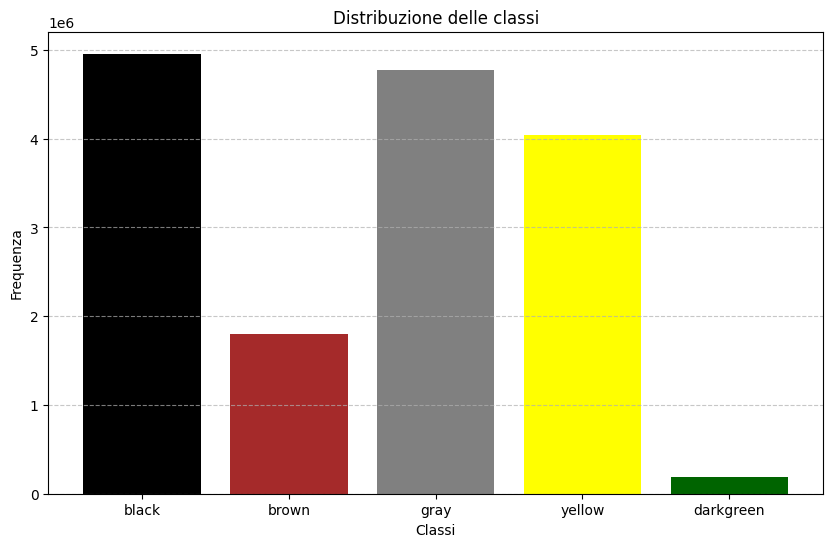

In [ ]:
# Distribuzione delle classi

# Istogramma delle classi
class_counts = np.zeros(len(class_colors), dtype=int)
for mask in y_train_check_new:
    for cls in range(len(class_colors)):
        class_counts[cls] += np.sum(mask == cls)

# Plot dell'istogramma
plt.figure(figsize=(10, 6))
plt.bar(class_colors.values(), class_counts, color=[class_colors[k] for k in class_colors])
plt.title("Distribuzione delle classi")
plt.xlabel("Classi")
plt.ylabel("Frequenza")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**CLASSE 2**

In [ ]:
# Estraggo solo le immagini che hanno % alta di classe 2
def find_image_with_at_least_90_percent_class_2(images, masks):

    X_img = []
    y_mask = []
    index = []

    for i, mask in enumerate(masks):
        unique, counts = np.unique(mask, return_counts=True)
        total_pixels = mask.size
        class_2_pixels = counts[unique == 2]

        # Verifica se almeno il 90% dei pixel è della classe 2
        if class_2_pixels > 0 and (class_2_pixels / total_pixels) >= 0.9:
            X_img.append(images[i])
            y_mask.append(mask)
            index.append(i)
    return np.array(X_img), np.array(y_mask), index

# Usa la funzione con i tuoi dati
X_img_2_09, y_mask_2_09, index_2_09 = find_image_with_at_least_90_percent_class_2(X_train_other_classes, y_train_other_classes)

if X_img_2_09 is not None:
    print("Trovata immagine con almeno il 90% di classe 2")
    print("Immagine shape:", X_img_2_09.shape)
    print("Maschera shape:", y_mask_2_09.shape)
else:
    print("Nessuna immagine trovata con almeno il 90% di classe 2")

<ipython-input-29-a0158b8c2d33>:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if class_2_pixels > 0 and (class_2_pixels / total_pixels) >= 0.9:


Trovata immagine con almeno il 30% di classe 1
Immagine shape: (304, 64, 128, 1)
Maschera shape: (304, 64, 128)


In [ ]:
# Cancello le immagini con gli indici di index_2_09 dal dataset X_train_other_classes

X_train_other_classes = np.delete(X_train_other_classes, index_2_09, axis=0)
print(X_train_other_classes.shape)

(1498, 64, 128, 1)


In [ ]:
# Cancello le maschere

y_train_other_classes = np.delete(y_train_other_classes, index_2_09, axis=0)
print(y_train_other_classes.shape)

(1498, 64, 128)


In [ ]:
# nuovo dataset di check

X_train_check_new2 = np.append(X_train_other_classes, X_train_class_4, axis=0)
y_train_check_new2 = np.append(y_train_other_classes, y_train_class_4, axis=0)
X_train_check_new2 = np.append(X_train_check_new2, X_aug_4, axis=0)
y_train_check_new2 = np.append(y_train_check_new2, y_aug_4, axis=0)
print(X_train_check_new2.shape)
print(y_train_check_new2.shape)

(1621, 64, 128, 1)
(1621, 64, 128)


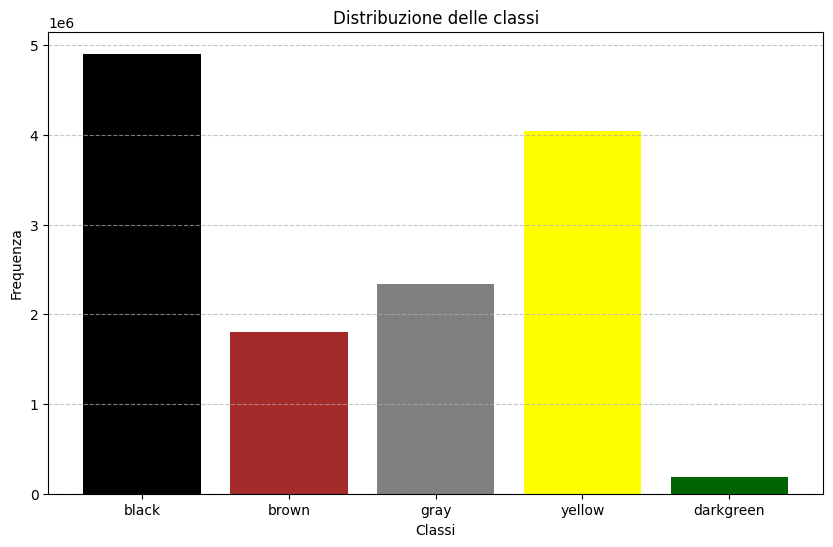

In [ ]:
# Distribuzione delle classi

# Istogramma delle classi
class_counts = np.zeros(len(class_colors), dtype=int)
for mask in y_train_check_new2:
    for cls in range(len(class_colors)):
        class_counts[cls] += np.sum(mask == cls)

# Plot dell'istogramma
plt.figure(figsize=(10, 6))
plt.bar(class_colors.values(), class_counts, color=[class_colors[k] for k in class_colors])
plt.title("Distribuzione delle classi")
plt.xlabel("Classi")
plt.ylabel("Frequenza")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**CLASSE 3**

In [ ]:
# Estraggo solo le immagini che hanno % alta di classe 3
def find_image_with_at_least_90_percent_class_3(images, masks):

    X_img = []
    y_mask = []
    index = []

    for i, mask in enumerate(masks):
        unique, counts = np.unique(mask, return_counts=True)
        total_pixels = mask.size
        class_3_pixels = counts[unique == 3]

        # Verifica se almeno il 90% dei pixel è della classe 3
        if class_3_pixels > 0 and (class_3_pixels / total_pixels) >= 0.9:
            X_img.append(images[i])
            y_mask.append(mask)
            index.append(i)
    return np.array(X_img), np.array(y_mask), index

# Usa la funzione con i tuoi dati
X_img_3_09, y_mask_3_09, index_3_09 = find_image_with_at_least_90_percent_class_3(X_train_other_classes, y_train_other_classes)

if X_img_3_09 is not None:
    print("Trovata immagine con almeno il 90% di classe 3")
    print("Immagine shape:", X_img_3_09.shape)
    print("Maschera shape:", y_mask_3_09.shape)
else:
    print("Nessuna immagine trovata con almeno il 90% di classe 3")

<ipython-input-34-81c82908d5da>:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if class_3_pixels > 0 and (class_3_pixels / total_pixels) >= 0.9:


Trovata immagine con almeno il 30% di classe 1
Immagine shape: (247, 64, 128, 1)
Maschera shape: (247, 64, 128)


In [ ]:
# Cancello le immagini con gli indici di index_3_09 dal dataset X_train_other_classes

X_train_other_classes = np.delete(X_train_other_classes, index_3_09, axis=0)
print(X_train_other_classes.shape)

(1251, 64, 128, 1)


In [ ]:
# Cancello le maschere

y_train_other_classes = np.delete(y_train_other_classes, index_3_09, axis=0)
print(y_train_other_classes.shape)

(1251, 64, 128)


In [ ]:
# nuovo dataset di check

X_train_check_new3 = np.append(X_train_other_classes, X_train_class_4, axis=0)
y_train_check_new3 = np.append(y_train_other_classes, y_train_class_4, axis=0)
X_train_check_new3 = np.append(X_train_check_new3, X_aug_4, axis=0)
y_train_check_new3 = np.append(y_train_check_new3, y_aug_4, axis=0)
print(X_train_check_new3.shape)
print(y_train_check_new3.shape)

(1374, 64, 128, 1)
(1374, 64, 128)


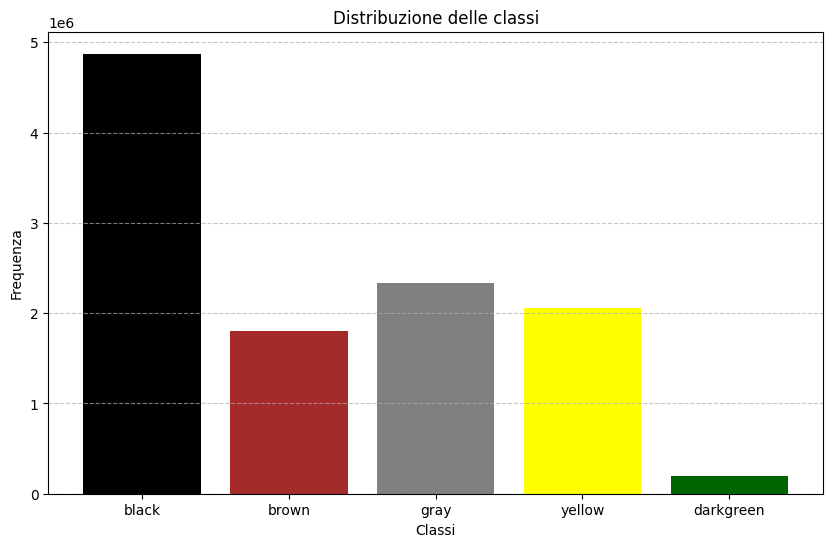

In [ ]:
# Distribuzione delle classi

# Istogramma delle classi
class_counts = np.zeros(len(class_colors), dtype=int)
for mask in y_train_check_new3:
    for cls in range(len(class_colors)):
        class_counts[cls] += np.sum(mask == cls)

# Plot dell'istogramma
plt.figure(figsize=(10, 6))
plt.bar(class_colors.values(), class_counts, color=[class_colors[k] for k in class_colors])
plt.title("Distribuzione delle classi")
plt.xlabel("Classi")
plt.ylabel("Frequenza")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Faccio per il background la stessa cosa:
def find_image_with_at_least_90_percent_class_0(images, masks):

    X_img = []
    y_mask = []
    index = []

    for i, mask in enumerate(masks):
        unique, counts = np.unique(mask, return_counts=True)
        total_pixels = mask.size
        class_0_pixels = counts[unique == 0]

        # Verifica se almeno il 80% dei pixel è della classe 0
        if class_0_pixels > 0 and (class_0_pixels / total_pixels) >= 0.8:
            X_img.append(images[i])
            y_mask.append(mask)
            index.append(i)
    return np.array(X_img), np.array(y_mask), index

# Usa la funzione con i tuoi dati
X_img_0_09, y_mask_0_09, index_0_09 = find_image_with_at_least_90_percent_class_0(X_train_other_classes, y_train_other_classes)

if X_img_0_09 is not None:
    print("Trovata immagine con almeno il 80% di classe 0")
    print("Immagine shape:", X_img_0_09.shape)
    print("Maschera shape:", y_mask_0_09.shape)
else:
    print("Nessuna immagine trovata con almeno il 80% di classe 0")

Trovata immagine con almeno il 30% di classe 1
Immagine shape: (248, 64, 128, 1)
Maschera shape: (248, 64, 128)


In [ ]:
# Cancello le immagini con gli indici di index_0_09 dal dataset X_train_other_classes

X_train_other_classes = np.delete(X_train_other_classes, index_0_09, axis=0)
print(X_train_other_classes.shape)

(1003, 64, 128, 1)


In [ ]:
# Cancello le maschere

y_train_other_classes = np.delete(y_train_other_classes, index_0_09, axis=0)
print(y_train_other_classes.shape)

(1003, 64, 128)


In [ ]:
# nuovo dataset di check

X_train_check_new4 = np.append(X_train_other_classes, X_train_class_4, axis=0)
y_train_check_new4 = np.append(y_train_other_classes, y_train_class_4, axis=0)
X_train_check_new4 = np.append(X_train_check_new4, X_aug_4, axis=0)
y_train_check_new4 = np.append(y_train_check_new4, y_aug_4, axis=0)
print(X_train_check_new4.shape)
print(y_train_check_new4.shape)

(1126, 64, 128, 1)
(1126, 64, 128)


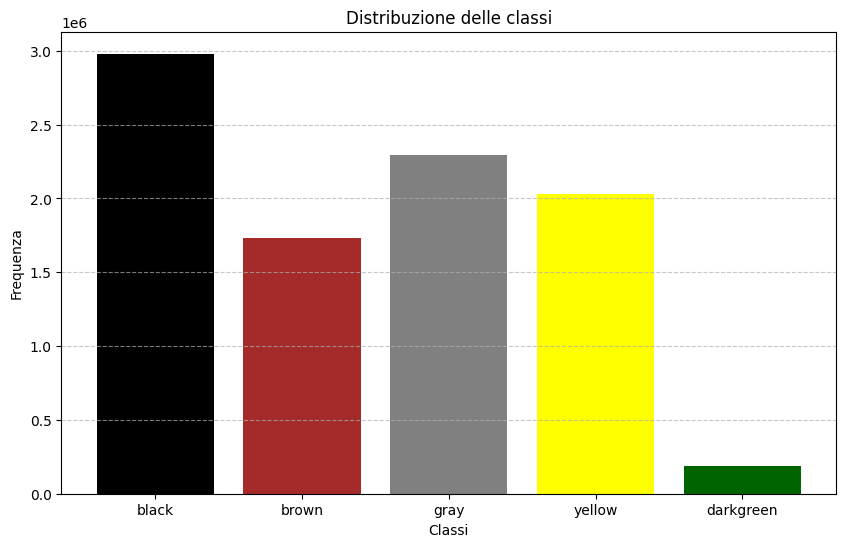

In [ ]:
# Distribuzione delle classi

# Istogramma delle classi
class_counts = np.zeros(len(class_colors), dtype=int)
for mask in y_train_check_new4:
    for cls in range(len(class_colors)):
        class_counts[cls] += np.sum(mask == cls)

# Plot dell'istogramma
plt.figure(figsize=(10, 6))
plt.bar(class_colors.values(), class_counts, color=[class_colors[k] for k in class_colors])
plt.title("Distribuzione delle classi")
plt.xlabel("Classi")
plt.ylabel("Frequenza")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Osservazione:** sbilanciamento ancora visibile e non ottimale.

In [ ]:
# Combina il dataset con la classe 4 e le altre classi
X_train_final = X_train_check_new3
y_train_final = y_train_check_new3

print(f"Nuovo X_train shape: {X_train_final.shape}")
print(f"Nuovo y_train shape: {y_train_final.shape}")

# check delle classi uniche e trasformo non in one hot
num_classes = len(np.unique(y_train_final))
print("Classi uniche nel dataset:", num_classes)

Nuovo X_train shape: (1374, 64, 128, 1)
Nuovo y_train shape: (1374, 64, 128)
Classi uniche nel dataset: 5
